<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Analyse-descriptive-avant-modélisation" data-toc-modified-id="Analyse-descriptive-avant-modélisation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Analyse descriptive avant modélisation</a></span><ul class="toc-item"><li><span><a href="#Import-des-packages-et-lecture-des-tables" data-toc-modified-id="Import-des-packages-et-lecture-des-tables-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import des packages et lecture des tables</a></span></li><li><span><a href="#Analyse-des-valeurs-manquantes" data-toc-modified-id="Analyse-des-valeurs-manquantes-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Analyse des valeurs manquantes</a></span></li><li><span><a href="#Analyse-des-valeurs-extrêmes" data-toc-modified-id="Analyse-des-valeurs-extrêmes-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Analyse des valeurs extrêmes</a></span><ul class="toc-item"><li><span><a href="#Analyse-des-variables-issues-de-BPE" data-toc-modified-id="Analyse-des-variables-issues-de-BPE-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Analyse des variables issues de BPE</a></span><ul class="toc-item"><li><span><a href="#Analyse-rapide-sans-regroupement" data-toc-modified-id="Analyse-rapide-sans-regroupement-1.3.1.1"><span class="toc-item-num">1.3.1.1&nbsp;&nbsp;</span>Analyse rapide sans regroupement</a></span></li><li><span><a href="#Analyse-avec-regroupement" data-toc-modified-id="Analyse-avec-regroupement-1.3.1.2"><span class="toc-item-num">1.3.1.2&nbsp;&nbsp;</span>Analyse avec regroupement</a></span></li><li><span><a href="#Détection-des-valeurs-extrêmes-en-utilisant-les-valeurs-adjacentes" data-toc-modified-id="Détection-des-valeurs-extrêmes-en-utilisant-les-valeurs-adjacentes-1.3.1.3"><span class="toc-item-num">1.3.1.3&nbsp;&nbsp;</span>Détection des valeurs extrêmes en utilisant les valeurs adjacentes</a></span></li></ul></li></ul></li></ul></li></ul></div>

# Analyse descriptive avant modélisation

Actuellement, nous disposons d'une table issue de la fusion de différences sources : DVF+open source, BPE, Filosofi. Cette table permet d'associer à chaque mutation (achat/vente d'appartements ou de maisons à Paris) des informations sur : 
- la distance aux équipements les plus proches
- des informations localisées sur les revenus, le tissu immobilier ...
- des informations sociodémographiques.

## Import des packages et lecture des tables

In [183]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [7]:
donnees = gpd.read_file("../../good_data/data/filo_service/paris_mutation_filo_service.shp")

## Analyse des valeurs manquantes

Récupération des lignes contenant au moins une valeur manquante : 

In [203]:
donnees_na = donnees[donnees.isnull().any(axis = 1)]

Il s'agit à chaque fois de mutations dont on ne connaît pas la position exacte.

<AxesSubplot:>

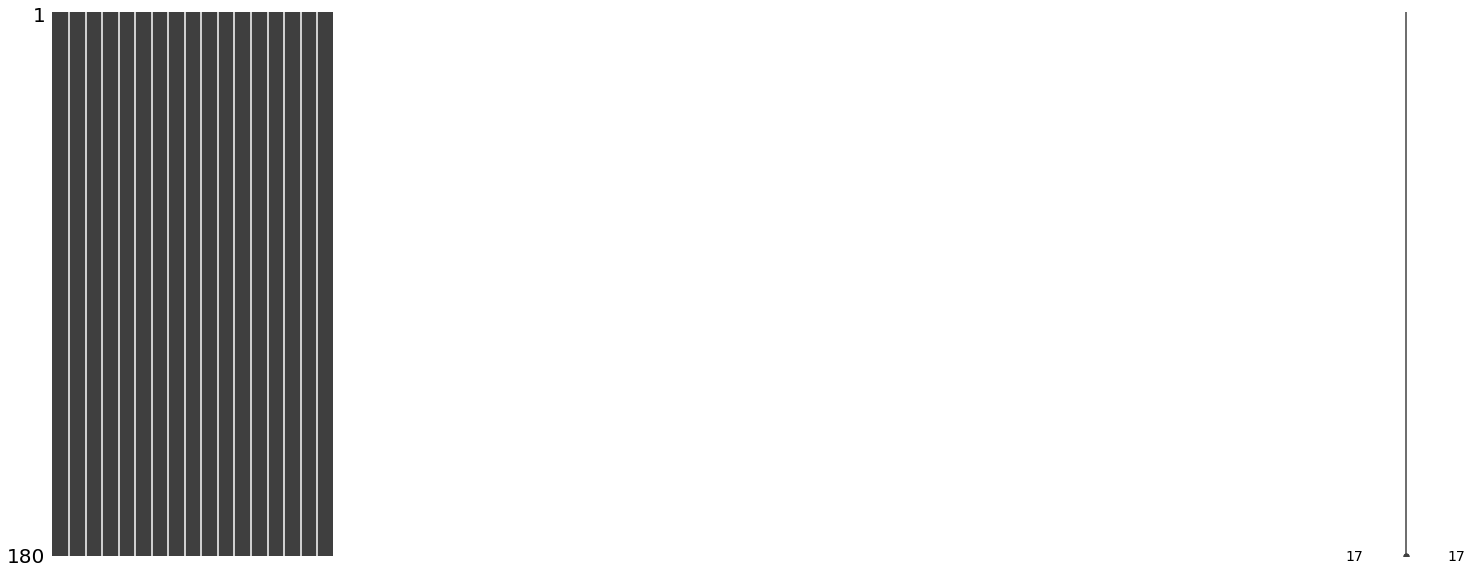

In [195]:
msno.matrix(donnees_na)

Ces mutations sont majoritairement présentes dans le 17ème et 18ème arrondissement.

In [202]:
donnees_na.l_codinsee.str[4:6].value_counts()

18    61
17    47
13    20
16    16
15    12
11     6
12     4
10     3
09     3
20     3
19     2
14     1
02     1
07     1
Name: l_codinsee, dtype: int64

Ces données sont inutilisables et correspondent à une part minime de notre jeu de données (environ 0.1%). Nous avons donc décidé de les supprimer.

In [206]:
donnees = donnees[~donnees.isnull().any(axis = 1)]

## Analyse des valeurs extrêmes

### Analyse des variables issues de BPE

#### Analyse rapide sans regroupement

<AxesSubplot:>

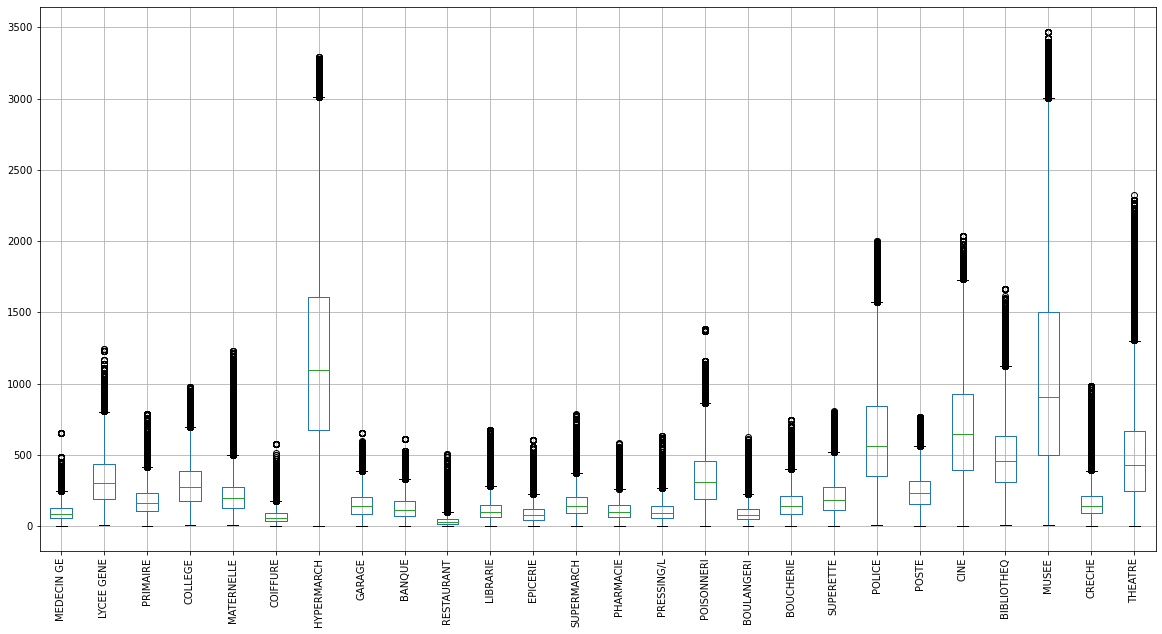

In [210]:
donnees.loc[:,"MEDECIN GE":"THEATRE"].boxplot(figsize = (20,10),rot = 90)

array([[<AxesSubplot:title={'center':'MEDECIN GE'}>,
        <AxesSubplot:title={'center':'LYCEE GENE'}>,
        <AxesSubplot:title={'center':'PRIMAIRE'}>,
        <AxesSubplot:title={'center':'COLLEGE'}>,
        <AxesSubplot:title={'center':'MATERNELLE'}>],
       [<AxesSubplot:title={'center':'COIFFURE'}>,
        <AxesSubplot:title={'center':'HYPERMARCH'}>,
        <AxesSubplot:title={'center':'GARAGE'}>,
        <AxesSubplot:title={'center':'BANQUE'}>,
        <AxesSubplot:title={'center':'RESTAURANT'}>],
       [<AxesSubplot:title={'center':'LIBRARIE'}>,
        <AxesSubplot:title={'center':'EPICERIE'}>,
        <AxesSubplot:title={'center':'SUPERMARCH'}>,
        <AxesSubplot:title={'center':'PHARMACIE'}>,
        <AxesSubplot:title={'center':'PRESSING/L'}>],
       [<AxesSubplot:title={'center':'POISONNERI'}>,
        <AxesSubplot:title={'center':'BOULANGERI'}>,
        <AxesSubplot:title={'center':'BOUCHERIE'}>,
        <AxesSubplot:title={'center':'SUPERETTE'}>,
        <Axe

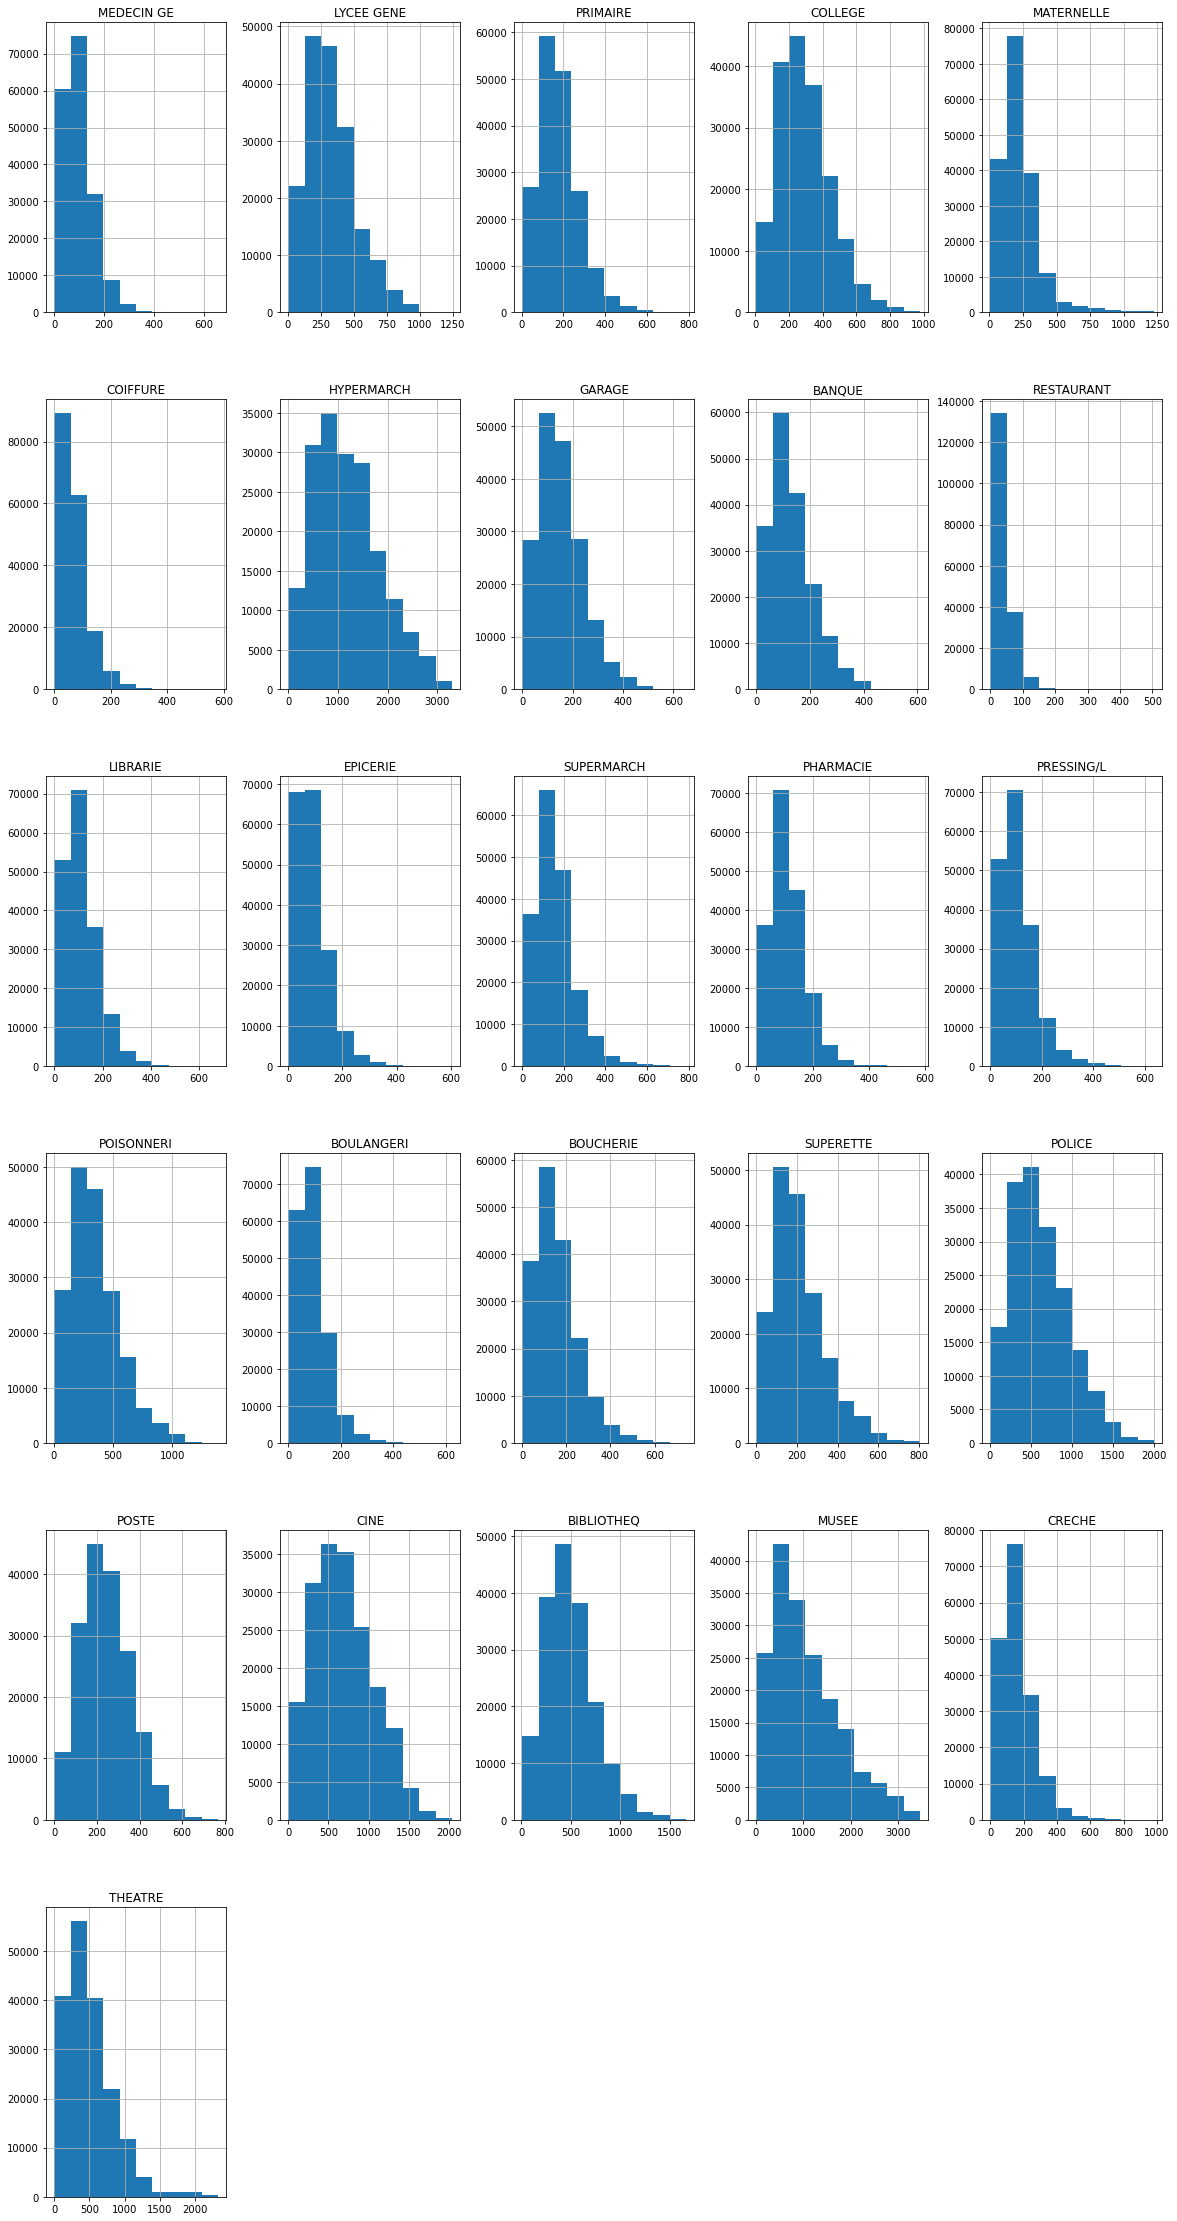

In [25]:
donnees.loc[:,"MEDECIN GE":"THEATRE"].hist(figsize = (20,40))

#### Analyse avec regroupement

Des regroupements de variables sont nécessaires dans le cadre de notre modélisation : 
- **COMMERCE** : Hypermarché (qui présente la plus forte hétérogénéité avec musée), épicerie, supermarché, supérette
- **CULTURE** : Théâtre, musée, bibliothèque, ciné, librarie
- **ENS_SEC** : Lycée général et collège
- **ENS_PRI** : Maternelle et primaire
- **CRECHE** : Crèche
- **MEDECIN** : Médecin généraliste
- **PHARMARCIE** : Pharmarcie
- **AUTRES_SERV**Coiffure, garage, banque, restaurant, Pressing, poste
- **AUTRES_ALIM** Boulangerie, boucherie, poisonnerie
- Police ? à retirer ?

Il suffit de prendre les mininums pour obtenir la distance au plus proche d'une catégorie.

In [211]:
donnees_bpe = pd.concat([donnees[["idmutation"]],donnees.loc[:,"MEDECIN GE":"THEATRE"]], axis = 1)

In [212]:
nouveau_regroupe = pd.DataFrame({"variable" : ['MEDECIN GE', 'LYCEE GENE', 'PRIMAIRE', 'COLLEGE',
       'MATERNELLE', 'COIFFURE', 'HYPERMARCH', 'GARAGE', 'BANQUE',
       'RESTAURANT', 'LIBRARIE', 'EPICERIE', 'SUPERMARCH', 'PHARMACIE',
       'PRESSING/L', 'POISONNERI', 'BOULANGERI', 'BOUCHERIE', 'SUPERETTE',
       'POLICE', 'POSTE', 'CINE', 'BIBLIOTHEQ', 'MUSEE', 'CRECHE', 'THEATRE'], 
             "regroup" : ['MEDECIN', 'ENS_SEC', 'ENS_PRI', 'ENS_SEC',
       'ENS_PRI', 'AUTRES_SERV', 'COMMERCE', 'AUTRES_SERV', 'AUTRES_SERV',
       'AUTRES_SERV', 'CULTURE', 'COMMERCE', 'COMMERCE', 'PHARMACIE',
       'AUTRES_SERV', 'AUTRES_ALIM', 'AUTRES_ALIM', 'AUTRES_ALIM', 'COMMERCE',
       'POLICE', 'AUTRES_SERV', 'CULTURE', 'CULTURE', 'CULTURE', 'CRECHE', 'CULTURE']})

In [213]:
dist_nouveau_regroupe = donnees_bpe.melt(id_vars = ["idmutation"]).merge(nouveau_regroupe, on = "variable", how = "left").groupby(["idmutation","regroup"])["value"].min()

donnees_bpe_nouveau_regroupe = dist_nouveau_regroupe.to_frame().reset_index(level = [0,1]).pivot(columns = "regroup", values = "value", index = "idmutation")
#Pour retirer le multiIndex en sortie du groupby on met un reset_index(level = [0,1])

<AxesSubplot:>

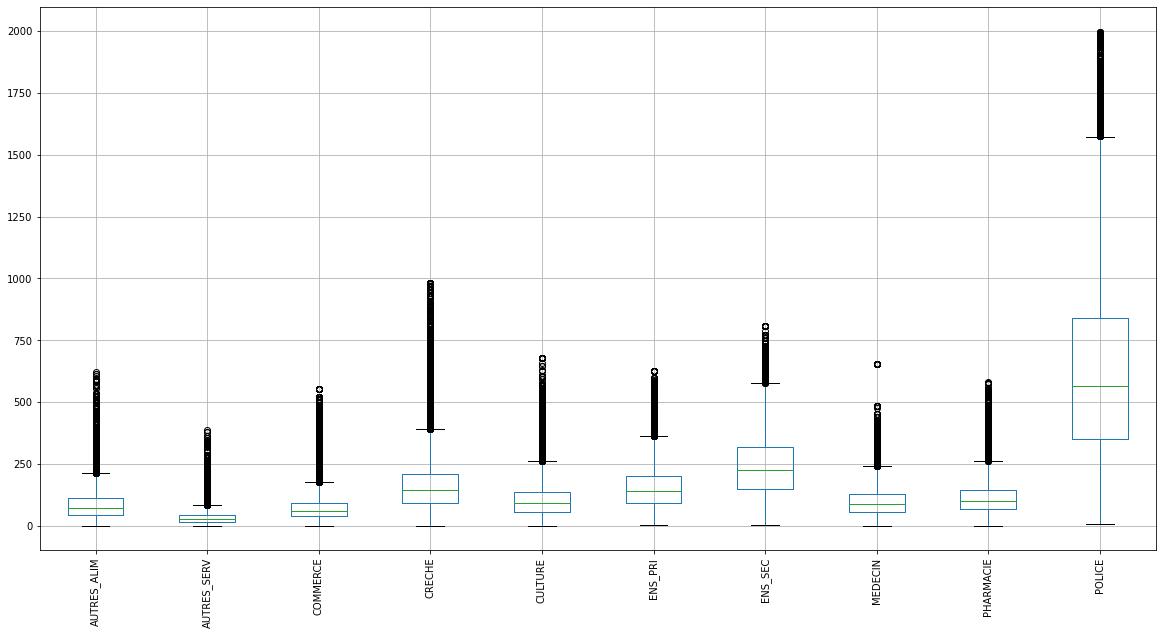

In [214]:
donnees_bpe_nouveau_regroupe.boxplot(figsize = (20,10),rot = 90)

#### Détection des valeurs extrêmes en utilisant les valeurs adjacentes

Les valeurs adjacentes correspondent aux valeurs seuils à partir desquelles les points sont affichés les boxplots précédents. 

Ces valeurs sont définies de la manière suivantes : 
- VAS = $\max \{ x_i / x_i \leq Q_3 + 1.5(Q_3 - Q_1) \}$ (valeur adjacente supérieure)
- VAI = $\min \{ x_i / x_i \geq Q_1 - 1.5(Q_3 - Q_1) \}$ (valeur adjacente infénieure)

In [215]:
#Cette fonction renvoie pour une Series les valeurs adjacentes supérieures et inférieurs.
def va(serie):
    quant = serie.quantile([0.25, 0.75])
    interquant = quant.iloc[1] - quant.iloc[0]
    seuil_inf, seuil_sup = quant.iloc[0] - 1.5*interquant, quant.iloc[1] + 1.5*interquant
    vas = serie[serie <= seuil_sup].max()
    vai = serie[serie >= seuil_inf].min()
    return vai, vas

In [238]:
va_bpe = donnees_bpe_nouveau_regroupe.apply(va)

In [276]:
val_ext_bpe = donnees_bpe_nouveau_regroupe.le(va_bpe.iloc[0,:], axis = 1) | donnees_bpe_nouveau_regroupe.ge(va_bpe.iloc[1,:], axis = 1)
nb_val_ext = val_ext_bpe.sum(axis = 1)

<AxesSubplot:>

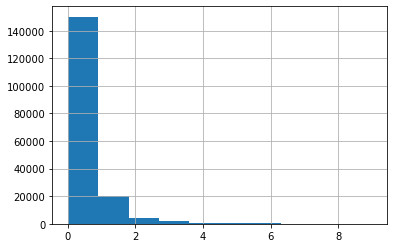

In [277]:
nb_val_ext.hist()

Elimination des mutations dont au moins 5 des 10 distances aux services sont extrêmes (0.5% du dataset)? 

In [279]:
100*nb_val_ext.value_counts(normalize = True)

0    84.119090
1    11.463199
2     2.476562
3     1.049542
4     0.376917
6     0.203300
5     0.185938
7     0.082328
9     0.026883
8     0.016242
dtype: float64

La valeur foncière médiane en fonction du nombre de distances aux services extrêmes : on remarque que la valeur est stable jusqu'à 8. À 8, on observe une baisse : cela apparaît cohérent --> bien éloigné de tout / moins valorisé.

Par contre, la valeur foncière médiane pour un bien éloigné de manière extrème à plus de 9 services (sur 10) est très supérieure aux autres valeurs médianes observées. Ceci semble contreintuitif.

<AxesSubplot:xlabel='nb_val_ext'>

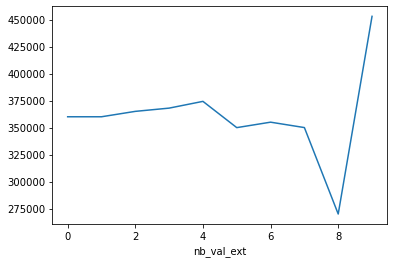

In [316]:
(nb_val_ext.to_frame("nb_val_ext").reset_index()).merge(donnees[["idmutation","valeurfonc"]], on = "idmutation", how = "left").groupby("nb_val_ext")["valeurfonc"].median().plot()

<AxesSubplot:>

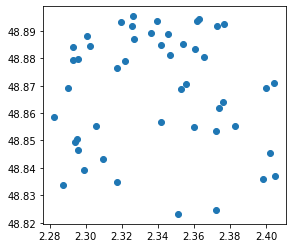

In [324]:
donnees[donnees.idmutation.isin(nb_val_ext[nb_val_ext == 9].index)].geometry.plot()